In [ ]:
# Execute the common model notebook
%run common_model.ipynb

# Create the model with constraints and objective
mdl, produccion_vars, products = create_model()

# Solve the model
solve_model(mdl)
    

Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 4700
* Total benefit=4700
Production of A: 0
Production of B: 80.0
Production of C: 50.0


In [ ]:
#***Added by JL - 2024 Mar 03th - Checking sensitivity analysis *****')

# Initialize lists to store the results

prices = []
quantities = []

real_price_value = 0

m = 0.01


In [ ]:
# Perform sensitivity analysis of the objective

def perform_sensitivity_analysis():
    lp = LinearRelaxer.make_relaxed_model(mdl)
    lp.solve()
    cpx = lp.get_engine().get_cplex()
    
    print("objective:", cpx.solution.sensitivity.objective())
    return cpx.solution.sensitivity.objective()


In [ ]:
# Solves the model for a given price por a product
# price: price to consider
# prod_name: product name ("A", "B", "C")
# prod_number: product number considering their position in the objective (1 = "A", 2 = "B", 3 = "C", ...)
def solve_model_for_price(price, prod_name, prod_number):

    # Función objetivo
    total_benefit = mdl.sum(produccion_vars[p] * (p[1] if p[0] != prod_name else price) for p in products)
    mdl.maximize(total_benefit)

    solution = mdl.solve()
    if solution is not None:
        print("* Production model solved with objective: {:g}".format(solution.objective_value))
        print("* Total benefit=%g" % solution.objective_value)
        for p in products:
            print("Production of {product}: {prod_var}".format(product=p[0], prod_var=produccion_vars[p].solution_value))

        return solution
    else:
        print("No solution found for price value: {0}".format(price))
        return None  # Return None to indicate that the model is infeasible at this point



In [ ]:
# Report values for the chart

def report(price, quantity):
    prices.append(price)
    quantities.append(quantity) 
    

In [ ]:
# Get quantity of the product in the solution
def get_quantity(prod_number):
    produccion_vars_list = list(produccion_vars.values())
    i = prod_number - 1
    if i >= 0:
        quantity = produccion_vars_list[i].solution_value
        return quantity
    else:
        return None

In [ ]:
# Iterate over prices (from 0 to infinity) starting from current price value
# prod_name: product name ("A", "B", "C")
# prod_number: product number considering their position in the objective (1 = "A", 2 = "B", 3 = "C", ...)
# price_position_in_products_vec: price position in products vector (0, 1, 2, ...)
def iterate_over_price(prod_name, prod_number, price_position_in_products_vec):
            
    # Perform initial sensitivity analysis to get the starting lower and upper bounds
    objective = perform_sensitivity_analysis()

    # Iterate over the lower and upper bounds of the objective of the given product
    for i in range(len(objective)): #Objective has all the coefficients for all products
        
        if i+1 == prod_number: #For the given product
            
            #Print price 0
            price = 0 
            solution = solve_model_for_price(price, prod_name, prod_number)
            quantity = get_quantity(prod_number)
            if quantity is not None:
                report(price, quantity)
            # ********* End of price 0 *********
            
            #Print real price
            prod_idx = prod_number - 1
            if (prod_idx >= 0):
                global real_price_value #use the global keyword to declare that you want the function to update the global variable
                real_price_value = products[prod_idx][price_position_in_products_vec] 
                solution = solve_model_for_price(real_price_value, prod_name, prod_number)
                quantity = get_quantity(prod_number)
                if quantity is not None:
                    report(real_price_value, quantity)
            # ********* End of real price *********
                    
            lower = objective[i][0] #Lower price of the current range
            upper = objective[i][1] #Upper price of the current range
    
            # *********Store and report the initial lower and upper bounds for the chart*********
            # Print the lower and upper bounds for price
            print("---Initial lower bound:", lower)            
            price = lower            
            if price >= 0:
                solution = solve_model_for_price(price, prod_name, prod_number)
                quantity = get_quantity(prod_number)
                if quantity is not None:
                    report(price, quantity)
                
            print("---Initial upper bound:", upper)
            price = upper
            # if price <= mdl.infinity:
            #    solution = solve_model_for_price(price, prod_name, prod_number)
            #    if solution is not None:
            #        quantity = get_quantity(prod_number)
            #        if quantity is not None:
            #            report(price, quantity)            
            # ********* End of lower and upper bounds *********
                       
            #Decrease price starting from lower bound - m
            price = lower - m

            while True:
                if price < 0:
                    break ## Stop if the price is lower than 0                
            
                solution = solve_model_for_price(price, prod_name, prod_number)
                if solution is None:
                    break  # Stop if the model is infeasible

                quantity = get_quantity(prod_number)
                if quantity is not None:
                    report(price+m, quantity) #(xq justo antes de entrar al while se le restó m)
                    
                # Perform sensitivity analysis to get the new lower bound
                new_objective = perform_sensitivity_analysis()
                # Iterate over the lower and upper bounds of the objective of the given product
                for i in range(len(new_objective)): #Objective has all the coefficients for all products

                    if i+1 == prod_number: #For the given product
                        new_lower = new_objective[i][0] #Lower price of the current range
                        #new_upper = new_objective[i][1] #Upper price of the current range
                        
                        price = new_lower
                        print("NEW LOWER:", new_lower)
                        if price < 0:
                            break ## Stop if the price is lower than 0                
                            
                        solution = solve_model_for_price(price, prod_name, prod_number)
                        if solution is None:
                            break  # Stop if the model is infeasible

                        quantity = get_quantity(prod_number)
                        if quantity is not None:
                            report(price, quantity)            
                             
                        price = new_lower - m

                        break


            # Increase price starting from upper bound + m
            price = upper + m
            
            while True:
                if price >= mdl.infinity:
                    break ## Stop if the price reaches or exceeds infinity

                solution = solve_model_for_price(price, prod_name, prod_number)
                
                if solution is None:
                    break  # Stop if the model is infeasible
                
                quantity = get_quantity(prod_number)
                if quantity is not None:
                    report(price-m, quantity) #(xq justo antes de entrar al while se le sumó m)

                # Perform sensitivity analysis to get the new upper bound
                new_objective = perform_sensitivity_analysis()
                # Iterate over the lower and upper bounds of the objective of the given product
                for i in range(len(new_objective)): #Objective has all the coefficients for all products

                    
                    if i+1 == prod_number: #For the given product
                        #new_lower = new_objective[i][0] #Lower price of the current range
                        new_upper = new_objective[i][1] #Upper price of the current range

                        price = new_upper
                        if price >= mdl.infinity:
                            break ## Stop if the price reaches or exceeds infinity

                        solution = solve_model_for_price(price, prod_name, prod_number)
                        if solution is None:
                            break  # Stop if the model is infeasible

                        quantity = get_quantity(prod_number)
                        if quantity is not None:
                            report(price, quantity)  

                        price = new_upper + m #aux: para la sgte vuelta del while
                        break
                        

In [ ]:
product_name = "A"
product_number = 1 # position of the product in the objective (1 = "A", 2 = "B", 3 = "C", ...)
price_position_in_products_vec = 1
iterate_over_price(product_name, product_number, price_position_in_products_vec)

objective: [(-1e+20, 30.0), (-1e+20, 50.0), (24.0, 1e+20)]
* Production model solved with objective: 4700
* Total benefit=4700
Production of A: 0
Production of B: 80.0
Production of C: 50.0
* Production model solved with objective: 4700
* Total benefit=4700
Production of A: 0
Production of B: 80.0
Production of C: 50.0
---Initial lower bound: -1e+20
---Initial upper bound: 30.0
* Production model solved with objective: 4700.5
* Total benefit=4700.5
Production of A: 50.0
Production of B: 80.0
Production of C: 0
objective: [(30.0, 1e+20), (-1e+20, 50.01666666666667), (-1e+20, 30.01)]


In [ ]:
# Plot the chart: quantity (Y) vs. price (X)

import matplotlib.pyplot as plt
import matplotlib


# Optional: xunit: unit to plot for x-axis
# Optional: yunit: unit to plot for y-axis
def plot(xunit, yunit):   
    
    global prices
    global quantities
    
     # Sort the prices and quantities based on the prices
    sorted_prices, sorted_quantities = zip(*sorted(zip(prices, quantities)))
    
    prices = sorted_prices
    quantitites = sorted_quantities
    
    # Round all values in the prices list to 2 decimal places
    rounded_prices = [round(price, 2) for price in prices]
    
    prices = rounded_prices

    print("prices:", prices)
    print("quantities:", quantitites)

    
    # Set default font size for all text elements
    matplotlib.rcParams.update({'font.size': 18})
    
    # Set the figure size to provide more space for the tick labels
    plt.figure(figsize=(10, 6))
    
    # Dibujar líneas horizontales entre los puntos
    for i in range(len(prices) - 1):
        plt.hlines(quantitites[i], prices[i], prices[i + 1], linewidth=6, color='C0')
        
    # Dibujar un vector con origen en el último punto y dirección hacia el infinito horizontalmente
    plt.annotate('', xy=(plt.xlim()[1], quantitites[-1]), xytext=(prices[-1], quantitites[-1]),
             arrowprops=dict(arrowstyle="->", lw=2, color='C0'))
          
        
    # Set the x-axis and y-axis ticks to the values we are printing
    # Iterate over the prices list in reverse order to avoid overlapping in the chart
    # i = len(prices) - 1
    # while i > 0:
    #     if abs(prices[i] - prices[i-1]) <= (m * (1.01)): #TODO: improve this. Now we are trying to avoid the overlapping between "29.99" and "30" in the chart 
    #         del prices[i-1]
    #     i -= 1
    # xticks_prices = prices
        
    #plt.xticks(xticks_prices)
    plt.xticks(prices)
    plt.yticks(quantitites)


    #Print current real value
    plt.axvline(x=real_price_value, color='g', linestyle='--', label='Valor actual')


    plt.xlabel('Precio {0}\n{1}'.format(product_name, xunit), labelpad=20, color='#DC143C')
    plt.ylabel('Cantidad \nProducida {0}\n{1}'.format(product_name, yunit), rotation=0, labelpad=90, color='#DC143C')
    plt.title('Curva de Oferta del Producto {}'.format(product_name), pad=30)
    plt.grid(True, which='both', linestyle='--', linewidth=0.2, color='gray', alpha=0.7)
    #plt.tight_layout()

    # debug
    print("[DEBUG]:")
    print("prices:", prices)
    #print("prices modifs:", xticks_prices)
    print("cant p:", quantitites)

    plt.show()  
    

In [ ]:
### Mejora1
# Armo pares y los ordeno según 'x'
pairs = []
for i in range(len(prices)):
    pairs.append((prices[i], quantities[i]))

print("pairs", pairs)

#pairs.sort()
# Ordeno ascendentemente por la primera componente y Asc por la segunda si hay empates
pairs.sort(key=lambda x: (x[0], x[1]))

print("pairs", pairs)

## Agrego acá la Mejora 2: elimino el 'infinito' si está
#print("aux:", pairs[-1][0])
# Podría No appendearse el infinito directam, tmb
# if pairs[-1][0] == mdl.infinity:
#     pairs.pop()
#     print("pairs", pairs)

# Los vuelvo a separar en listas, para no cambiar la función plot
new_x, new_y = [], []
for elem in pairs:
    new_x.append(elem[0])
    new_y.append(elem[1])
print("new_x", new_x)
print("new_y", new_y)

pairs [(0, 0), (10, 0), (30.0, 50.0)]
pairs [(0, 0), (10, 0), (30.0, 50.0)]
new_x [0, 10, 30.0]
new_y [0, 0, 50.0]


prices: [0, 10, 30.0]
quantities: (0, 0, 50.0)
[DEBUG]:
prices: [0, 10, 30.0]
cant p: (0, 0, 50.0)


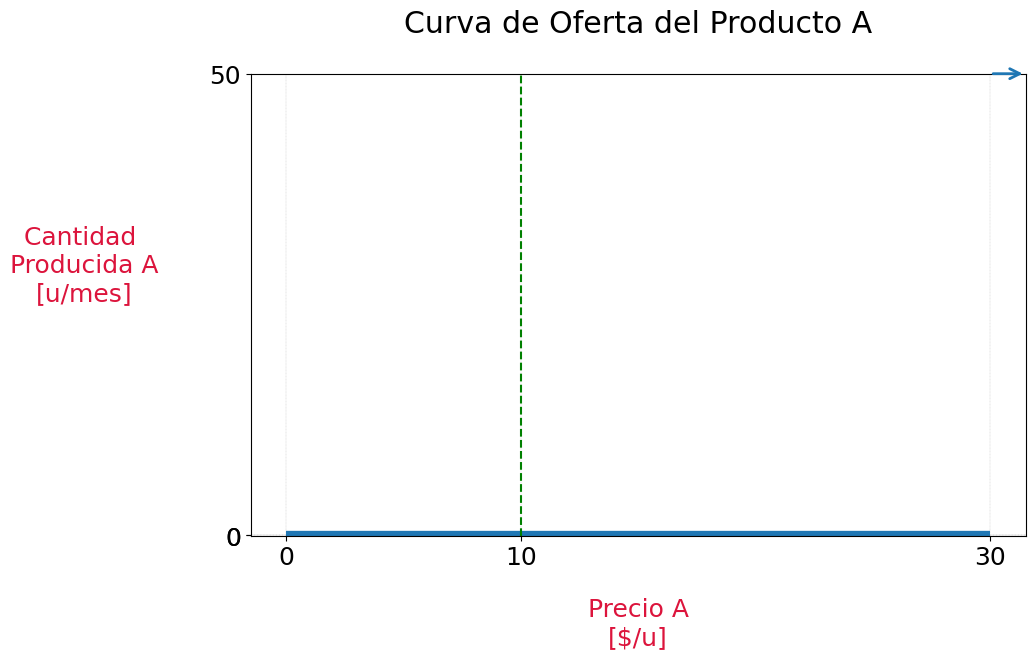

In [ ]:
# Usage of pLot the chart
plot("[$/u]", "[u/mes]")